# Non Parametric Regression with Gradient Boosting

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as graph
from multiprocessing import cpu_count

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

graph.style.use('fivethirtyeight')

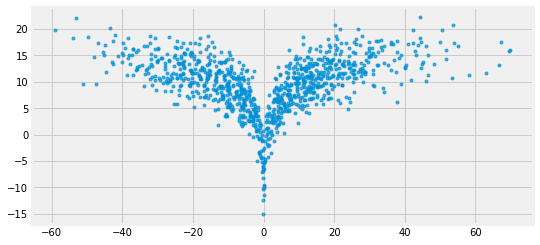

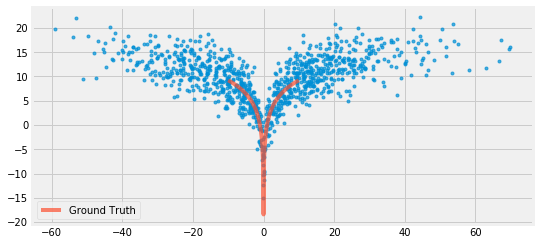

In [2]:
def f(z):
    return 4 * np.log(np.abs(z))

x = stats.norm(0, 20).rvs(size=(1000, 1))
y = f(x) + stats.norm(0, 3).rvs(size=x.shape)
y = y.flatten()

xs = np.linspace(-10, 10, 1000)

graph.figure(figsize=(8, 4))
graph.plot(x, y, '.', alpha=0.7)
graph.show()

graph.figure(figsize=(8, 4))
graph.plot(x, y, '.', alpha=0.7)
graph.plot(xs, f(xs), alpha=0.7, label='Ground Truth')
graph.legend()
graph.show()

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

# Gradient Boosting

In [4]:
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

In [5]:
%%time
gbm = GradientBoostingRegressor(n_estimators=2000)
gbm.fit(x_train, y_train)

CPU times: user 297 ms, sys: 197 µs, total: 298 ms
Wall time: 297 ms


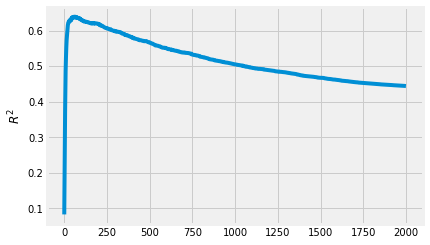

Best trees = 60


In [6]:
test_scores =  np.zeros(gbm.n_estimators)

for i, y_staged_pred in enumerate(gbm.staged_predict(x_test)):
    test_scores[i] = r2_score(y_test, y_staged_pred)
    
graph.plot(test_scores)
graph.ylabel(r'$R^2$')
graph.show()

best_n = np.argmax(test_scores)
print(f'Best trees = {best_n}')

In [7]:
gbm = GradientBoostingRegressor(n_estimators=best_n).fit(x_train, y_train)

GT = 0.6837350528957736
GB = 0.6382204902353434


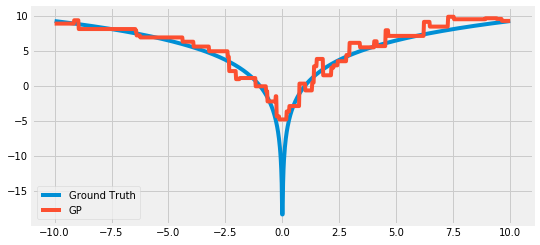

In [8]:
print(f'GT = {r2_score(y_test, f(x_test))}')
print(f'GB = {r2_score(y_test, gbm.predict(x_test))}')

graph.figure(figsize=(8, 4))
graph.plot(xs, f(xs), label='Ground Truth')
graph.plot(xs, gbm.predict(np.asmatrix(xs).T), label='GP')
graph.legend()
graph.show()

In [9]:
best_gbm = GradientBoostingRegressor(n_estimators=best_n)
best_gbm.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=60, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [10]:
%%time
bootstrapped_gbm = BaggingRegressor(
    GradientBoostingRegressor(n_estimators=best_n), 
    n_estimators=1000, n_jobs=-1
)
bootstrapped_gbm.fit(x_train, y_train)

CPU times: user 1.11 s, sys: 257 ms, total: 1.37 s
Wall time: 3.15 s


GT  = 0.6837350528957736
BGM = 0.6453006644036274


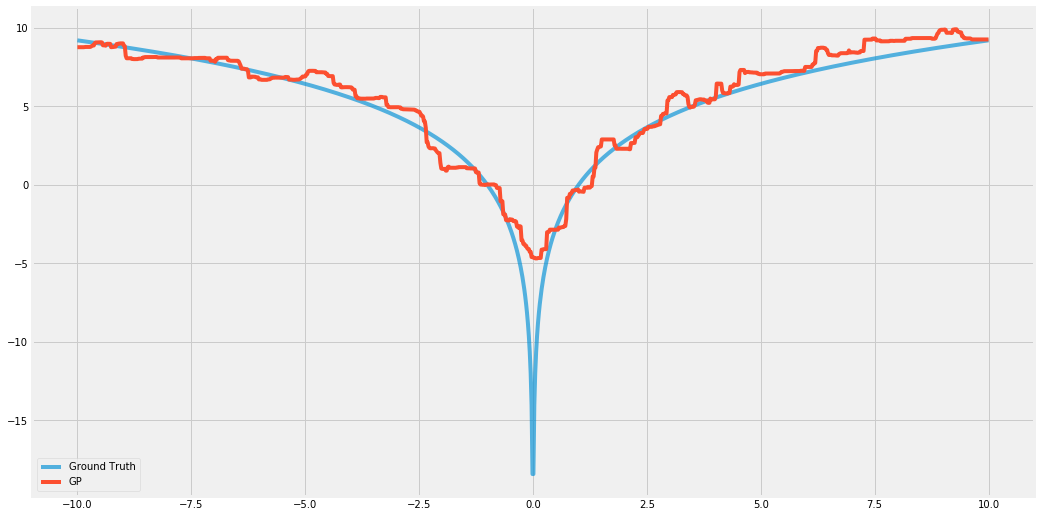

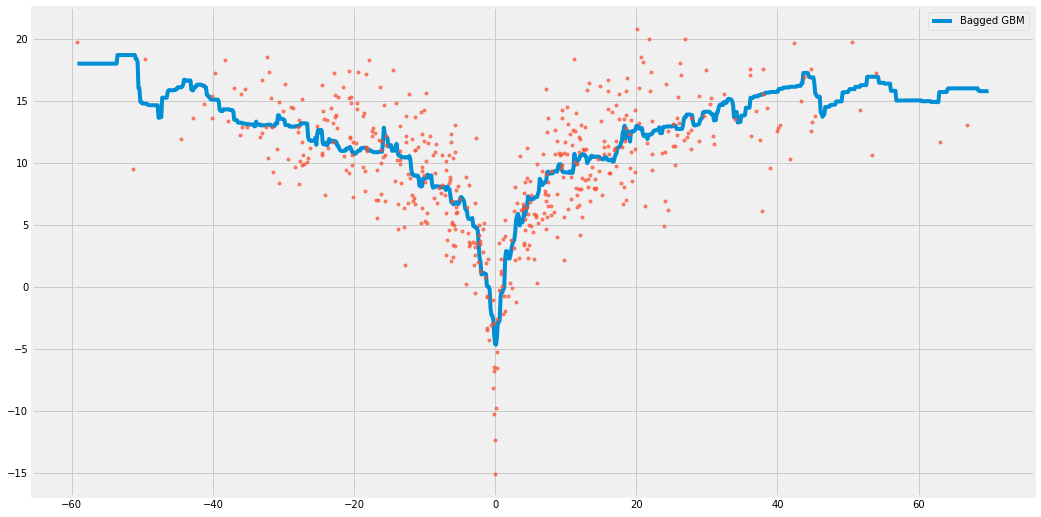

In [11]:
print(f'GT  = {r2_score(y_test, f(x_test))}')
print(f'BGM = {r2_score(y_test, bootstrapped_gbm.predict(x_test))}')

graph.figure(figsize=(16, 9))
graph.plot(xs, f(xs), label='Ground Truth', alpha=0.66)
graph.plot(xs, bootstrapped_gbm.predict(np.asmatrix(xs).T), label='GP')
graph.legend()
graph.show()

sweep = np.linspace(x.max(), x.min(), 1000)

graph.figure(figsize=(16, 9))
graph.plot(sweep, bootstrapped_gbm.predict(np.asmatrix(sweep).T), label='Bagged GBM')
graph.plot(x_test, y_test, '.', alpha=0.66)
graph.legend()
graph.show()

# XGBoost Gradient Boosting Implementation

In [12]:
from xgboost import XGBRegressor

In [13]:
%%time
xgb = XGBRegressor(learning_rate=0.01, n_estimators=5000, n_jobs=cpu_count())
xgb.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=3, verbose=False)

CPU times: user 1.28 s, sys: 6.7 ms, total: 1.29 s
Wall time: 183 ms


GT  = 0.6837350528957736
XGB = 0.6282675230610423


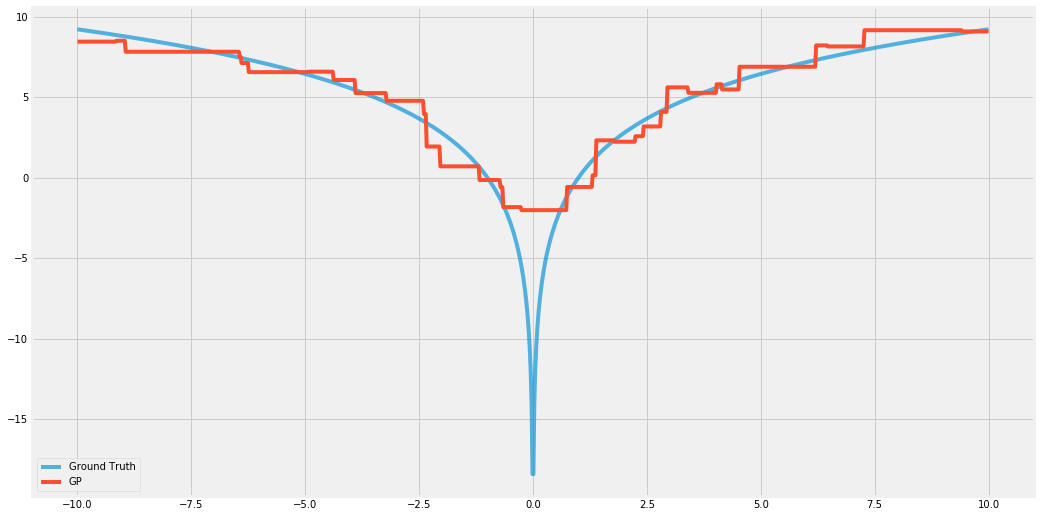

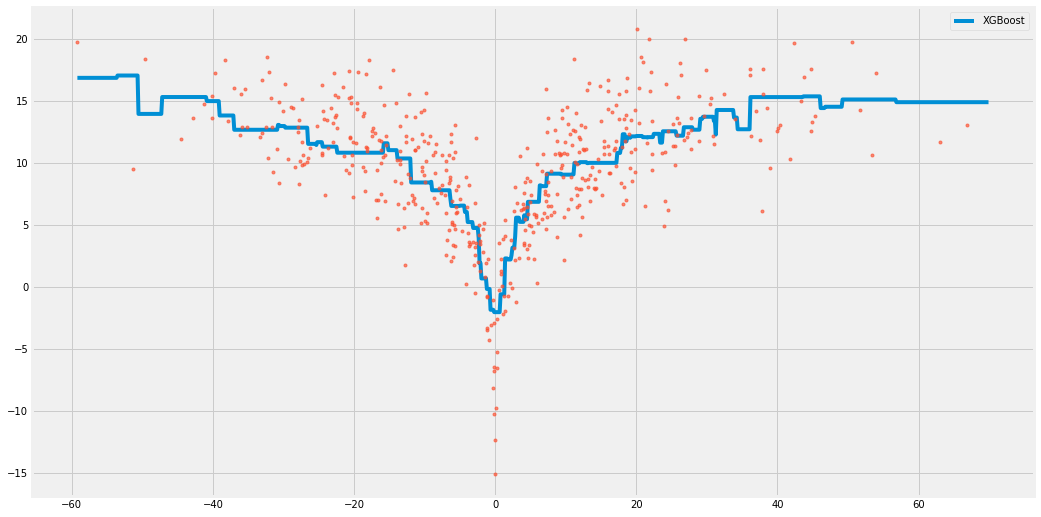

In [14]:
print(f'GT  = {r2_score(y_test, f(x_test))}')
print(f'XGB = {r2_score(y_test, xgb.predict(x_test))}')

graph.figure(figsize=(16, 9))
graph.plot(xs, f(xs), label='Ground Truth', alpha=0.66)
graph.plot(xs, xgb.predict(np.asmatrix(xs).T), label='GP')
graph.legend()
graph.show()

sweep = np.linspace(x.max(), x.min(), 1000)

graph.figure(figsize=(16, 9))
graph.plot(sweep, xgb.predict(np.asmatrix(sweep).T), label='XGBoost')
graph.plot(x_test, y_test, '.', alpha=0.66)
graph.legend()
graph.show()

# All Model Fits

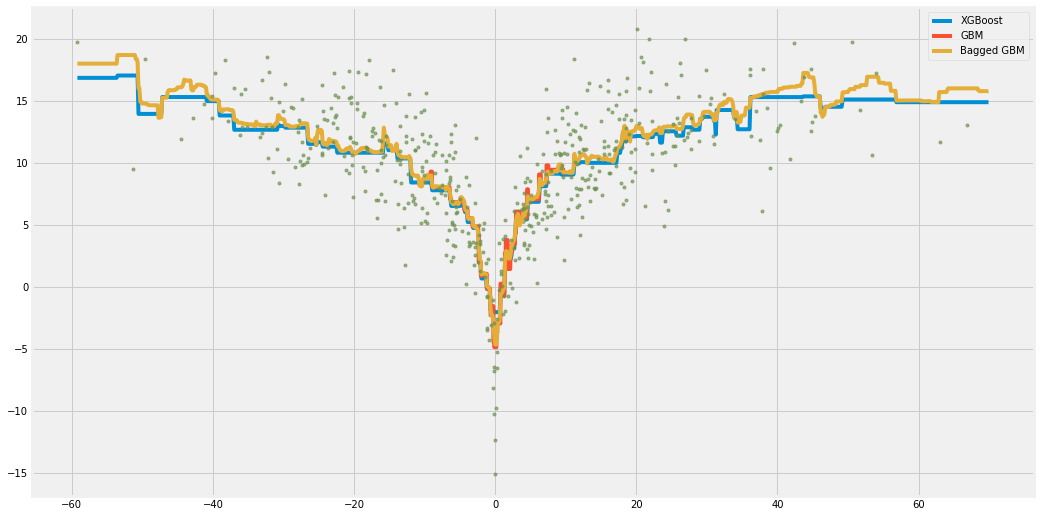

In [15]:
graph.figure(figsize=(16, 9))
graph.plot(sweep, xgb.predict(np.asmatrix(sweep).T), label='XGBoost')
graph.plot(xs, gbm.predict(np.asmatrix(xs).T), label='GBM')
graph.plot(sweep, bootstrapped_gbm.predict(np.asmatrix(sweep).T), label='Bagged GBM')
graph.plot(x_test, y_test, '.', alpha=0.66)
graph.legend()
graph.show()